<a href="https://colab.research.google.com/github/jnsbrdbr/AD-MRI/blob/master/jpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.13.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

In [ ]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/archive(2)/Alzheimer_s Dataset/train",
validation_split=0.2,
subset='training',
seed=1337,
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE,
)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [ ]:
val_ds= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/archive(2)/Alzheimer_s Dataset/train",
validation_split=0.2,
subset='validation',
seed=1337,
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE,
)


Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
class_name=['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
train_ds.class_names=class_name
val_ds.class_names=class_name
NUM_classes=len(class_name)

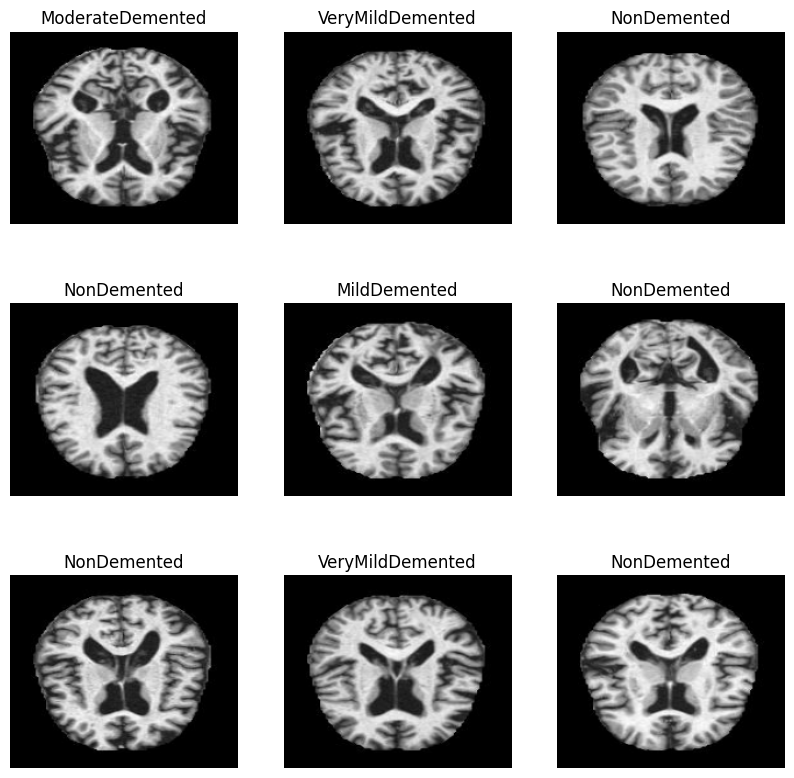

In [ ]:
#data_visualization

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')

In [ ]:
#feature_engineering
def one_hot_label(image,label):
  label=tf.one_hot(label,NUM_classes)
  return image,label

train_ds=train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#the_dataset_is_imbalance
NUM_IMAGES = []

for label in class_name:
    dir_name = "/content/drive/MyDrive/Colab Notebooks/archive(2)/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
NUM_IMAGES

[717, 52, 2560, 1792]

In [ ]:
#Build_the_ML_Model
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_classes, activation='softmax')
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - ETA: 0s - loss: 1.0976 - auc: 0.7822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 538s 2s/step - loss: 1.0976 - auc: 0.7822 - val_loss: 7.5019 - val_auc: 0.6760 - lr: 0.0100
Epoch 2/100
257/257 [==============================] - 405s 2s/step - loss: 0.9763 - auc: 0.8125 - val_loss: 1.0955 - val_auc: 0.7510 - lr: 0.0089
Epoch 3/100
257/257 [==============================] - 392s 2s/step - loss: 0.9754 - auc: 0.8093 - val_loss: 128.4387 - val_auc: 0.6634 - lr: 0.0079
Epoch 4/100
257/257 [==============================] - 385s 1s/step - loss: 0.9667 - auc: 0.8128 - val_loss: 0.9595 - val_auc: 0.8187 - lr: 0.0071
Epoch 5/100
257/257 [==============================] - 391s 2s/step - loss: 0.9621 - auc: 0.8144 - val_loss: 1.1072 - val_auc: 0.7404 - lr: 0.0063
Epoch 6/100
257/257 [==============================] - 409s 2s/step - loss: 0.9507 - auc: 0.8190 - val_loss: 1.6257 - val_auc: 0.7565 - lr: 0.0056
Epoch 7/100
257/257 [==============================] - 405s 2s/step - loss: 0.9393 - auc: 0.8231 - val_loss: 4.7930 - val_auc: 0

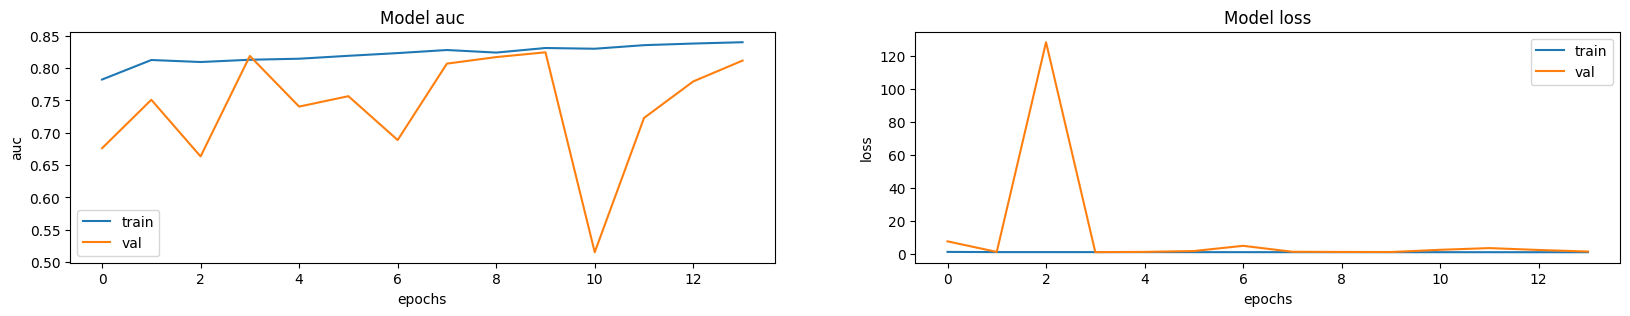

In [19]:
#visualization
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
#Evaluate_the_Model
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/archive(2)/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [21]:

_ = model.evaluate(test_ds)


80/80 [==============================] - 116s 1s/step - loss: 0.9392 - auc: 0.8234
